<a href="https://colab.research.google.com/github/poonsnote/NLP/blob/main/Seq2Seq_with_attention(Translation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation Model (Seq2Seq with attention)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import os
import io
import time
import re
import pandas as pd
from tqdm.notebook import tqdm
import nltk.translate.bleu_score
import random

## Data Preprocessing

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
lines = lines[:50000]
random.shuffle(lines)
lines = lines[:(int(len(lines)*0.9))]
test_lines = lines[(int(len(lines)*0.9)):]

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')
  
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w= w.strip()
    w= '<start> ' + w + ' <end>'
    return w

def create_dataset(data):
    word_pairs =[[preprocess_sentence(w) for w in l.split('\t')] for l in data]
    return zip(*word_pairs)

In [ ]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '',oov_token='OOV')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post',truncating='post')
    return tensor, lang_tokenizer

def load_dataset(data):
    targ_lang, inp_lang = create_dataset(data)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(lines)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

## Attention Modeling

### Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True)
        
    def call(self, x):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x)
        return output, [state_h, state_c]

### Attention Mechanism

In [ ]:
class AdditiveAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(AdditiveAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query,1)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis)+self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class MultiplicativeAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(MultiplicativeAttention, self).__init__()
    self.W = tf.keras.layers.Dense(units)
  
  def call(self, decoder_output, encoder_output):
    score = tf.matmul(decoder_output ,self.W(encoder_output), transpose_b=True)
    alignment = tf.nn.softmax(score, axis=2)

    context_vector = tf.matmul(alignment, encoder_output)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, alignment

In [ ]:
class DotProductAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(DotProductAttention, self).__init__()

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    values_transposed = tf.transpose(values, perm=[0, 2, 1])
    score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [ ]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(ScaledDotProductAttention, self).__init__()

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    values_transposed = tf.transpose(values, perm=[0, 2, 1])
    score = tf.transpose((tf.matmul(query_with_time_axis, values_transposed))/np.sqrt(units) , perm=[0, 2, 1])
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, is_attention=False):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.is_attention = is_attention
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(self.dec_units, return_sequences=True, return_state=True)
        if is_attention =='AdditiveAttention':
          self.attn = AdditiveAttention(dec_units)
        elif is_attention =='MultiplicativeAttention':
          self.attn = MultiplicativeAttention(dec_units)
        elif is_attention =='DotProductAttention':
          self.attn = DotProductAttention(dec_units)
        elif is_attention =='ScaledDotProductAttention':
          self.attn = ScaledDotProductAttention(dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
    def call(self,x, enc_states,enc_outputs=None):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state=enc_states)
        attn_weight = None
        if self.is_attention:
          context_vector, attn_weight = self.attn(state_h, enc_outputs)
          output = tf.concat([tf.expand_dims(context_vector, 1), output],axis=-1)

        output = self.fc(output)
        return output, [state_h, state_c],attn_weight

### Seq2Seq with Attention

In [ ]:
class Seq2Seq(tf.keras.Model):
  def __init__(self, inp_vocab_size, tar_vocab_size, embedding_dim, units,is_attention=False):
    super(Seq2Seq, self).__init__()
    self.encoder = Encoder(inp_vocab_size, embedding_dim, units)
    self.decoder = Decoder(tar_vocab_size, embedding_dim, units,is_attention=is_attention)
      
  def call(self, x):
    enc_inp, dec_inp = x
    enc_out, enc_states = self.encoder(enc_inp)
    dec_out, dec_states = self.decoder(dec_inp, enc_states,enc_out)
    return dec_out

## Training & Test

In [ ]:
BATCH_SIZE = 128
embedding_dim = 512
units = 256 
EPOCHS = 10 
steps_per_epoch = len(input_tensor)//BATCH_SIZE

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

### AdditiveAttention

In [ ]:
seq2seq = Seq2Seq(vocab_inp_size, vocab_tar_size, embedding_dim, units,is_attention='AdditiveAttention')

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ):
  loss = 0
  with tf.GradientTape() as tape:
      enc_output, enc_states = seq2seq.encoder(inp)
      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
      for t in range(1, targ.shape[1]):
          predictions, dec_states, attn_weight = seq2seq.decoder(dec_input,enc_states,enc_output)
          loss += loss_function(targ[:, t], predictions)
          dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = seq2seq.encoder.trainable_variables + seq2seq.decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  
  for (batch, (inp,targ)) in enumerate(train_dataset.take(steps_per_epoch)):
      batch_loss = train_step(inp, targ)
      total_loss += batch_loss
      
      if batch % 100 == 0:
          print('Epoch %i Batch %i Loss %0.4f' % (epoch+1, batch, batch_loss.numpy()))
          
  print('Epoch %i Loss %0.4f' % (epoch+1, total_loss/steps_per_epoch))
  print('Time taken for 1 epoch %0.4f sec\n' % (time.time()-start))

Epoch 1 Batch 0 Loss 4.7838
Epoch 1 Batch 100 Loss 2.2741
Epoch 1 Batch 200 Loss 2.2128
Epoch 1 Batch 300 Loss 1.9815
Epoch 1 Loss 2.3116
Time taken for 1 epoch 78.3974 sec

Epoch 2 Batch 0 Loss 1.8566
Epoch 2 Batch 100 Loss 1.7515
Epoch 2 Batch 200 Loss 1.7601
Epoch 2 Batch 300 Loss 1.5968
Epoch 2 Loss 1.6981
Time taken for 1 epoch 39.1606 sec

Epoch 3 Batch 0 Loss 1.4838
Epoch 3 Batch 100 Loss 1.4045
Epoch 3 Batch 200 Loss 1.4485
Epoch 3 Batch 300 Loss 1.2655
Epoch 3 Loss 1.3727
Time taken for 1 epoch 38.9822 sec

Epoch 4 Batch 0 Loss 1.1985
Epoch 4 Batch 100 Loss 1.1221
Epoch 4 Batch 200 Loss 1.1736
Epoch 4 Batch 300 Loss 1.0084
Epoch 4 Loss 1.0936
Time taken for 1 epoch 39.1584 sec

Epoch 5 Batch 0 Loss 0.9304
Epoch 5 Batch 100 Loss 0.8826
Epoch 5 Batch 200 Loss 0.9389
Epoch 5 Batch 300 Loss 0.7717
Epoch 5 Loss 0.8501
Time taken for 1 epoch 39.0570 sec

Epoch 6 Batch 0 Loss 0.6818
Epoch 6 Batch 100 Loss 0.6530
Epoch 6 Batch 200 Loss 0.7110
Epoch 6 Batch 300 Loss 0.5620
Epoch 6 Loss

In [ ]:
def translate(model, sentence):
  attn_weights = np.zeros((max_length_targ, max_length_inp)) 
  inputs = [inp_lang.word_index[i] if i in inp_lang.word_index.keys() else 1 for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post',truncating='post')  
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  enc_out, enc_states = seq2seq.encoder(inputs)
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
  
  for t in range(max_length_targ):
    
    prediction, dec_states, attn_weight = seq2seq.decoder(dec_input, enc_states, enc_out)
    attn_weight = tf.reshape(attn_weight, (-1,))
    attn_weights[t] = attn_weight.numpy()
    prediction_id = max(1,tf.argmax(prediction, axis=-1).numpy()[0,0])
    
    prediction_word = targ_lang.index_word[prediction_id]  
    result += prediction_word + ' '

    
    if prediction_word == '<end>':
        break
    dec_input = tf.expand_dims([prediction_id], 0)
    
  return result, attn_weights

In [ ]:
en,sp = create_dataset(test_lines)

In [ ]:
en_length = []
bleu_list = []
for i in tqdm(range(len(en))):
  sp_sentence = sp[i][8:-6]
  en_sentence = en[i][8:-6]
  result, attn_weights = translate(seq2seq, sp_sentence)
  if i%300==1:
    print('en :', en_sentence)
    print('pred :', result)
  bleu_score = nltk.translate.bleu_score.sentence_bleu([en_sentence], result[:-6], smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
  en_length.append(len(en_sentence.split(' ')))
  bleu_list.append(bleu_score)

AdditiveAttention_df = pd.DataFrame([en_length,bleu_list]).T

en : you deserve a present .
pred : you a present . <end> 
en : tom is feeling nauseous .
pred : tom is feeling nauseous . <end> 
en : i ve heard that .
pred : i didn t hear that . <end> 
en : she wants to kiss him .
pred : she wants him . <end> 
en : i am like my brother .
pred : i am like my brother . <end> 
en : tom never said a word .
pred : he never told a word . <end> 
en : why did tom come back ?
pred : why did tom come back ? <end> 
en : i can t even look at you .
pred : i can t even look at you . <end> 
en : i need to go get my laptop .
pred : i need to go of my laptop . <end> 
en : i ll come if necessary .
pred : i ve got it s necessary . <end> 
en : don t be shy .
pred : don t be shy . <end> 
en : i was going to use that .
pred : i was going to use that . <end> 
en : tom actually believed you .
pred : i thought you thought you thought you thought you thought you thought 
en : this is my star pupil .
pred : this is my star pupil . <end> 
en : she married young .
pred : she ma

### DotProductAttention

In [ ]:
seq2seq = Seq2Seq(vocab_inp_size, vocab_tar_size, embedding_dim, units,is_attention='DotProductAttention')

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_states = seq2seq.encoder(inp)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_states, attn_weight = seq2seq.decoder(dec_input,enc_states,enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = seq2seq.encoder.trainable_variables + seq2seq.decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (inp,targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch %i Batch %i Loss %0.4f' % (epoch+1, batch, batch_loss.numpy()))
            
    print('Epoch %i Loss %0.4f' % (epoch+1, total_loss/steps_per_epoch))
    print('Time taken for 1 epoch %0.4f sec\n' % (time.time()-start))

Epoch 1 Batch 0 Loss 4.7842
Epoch 1 Batch 100 Loss 2.2924
Epoch 1 Batch 200 Loss 2.2087
Epoch 1 Batch 300 Loss 1.9770
Epoch 1 Loss 2.3116
Time taken for 1 epoch 74.8880 sec

Epoch 2 Batch 0 Loss 1.8730
Epoch 2 Batch 100 Loss 1.7627
Epoch 2 Batch 200 Loss 1.7588
Epoch 2 Batch 300 Loss 1.5829
Epoch 2 Loss 1.7003
Time taken for 1 epoch 37.1886 sec

Epoch 3 Batch 0 Loss 1.4795
Epoch 3 Batch 100 Loss 1.3907
Epoch 3 Batch 200 Loss 1.4262
Epoch 3 Batch 300 Loss 1.2575
Epoch 3 Loss 1.3525
Time taken for 1 epoch 36.9664 sec

Epoch 4 Batch 0 Loss 1.1531
Epoch 4 Batch 100 Loss 1.0977
Epoch 4 Batch 200 Loss 1.1537
Epoch 4 Batch 300 Loss 1.0004
Epoch 4 Loss 1.0701
Time taken for 1 epoch 36.9228 sec

Epoch 5 Batch 0 Loss 0.9139
Epoch 5 Batch 100 Loss 0.8722
Epoch 5 Batch 200 Loss 0.9186
Epoch 5 Batch 300 Loss 0.7968
Epoch 5 Loss 0.8509
Time taken for 1 epoch 36.9812 sec

Epoch 6 Batch 0 Loss 0.7345
Epoch 6 Batch 100 Loss 0.7002
Epoch 6 Batch 200 Loss 0.7438
Epoch 6 Batch 300 Loss 0.6430
Epoch 6 Loss

In [ ]:
en_length = []
bleu_list = []
for i in tqdm(range(len(en))):
  sp_sentence = sp[i][8:-6]
  en_sentence = en[i][8:-6]
  result, attn_weights = translate(seq2seq, sp_sentence)
  if i%300==1:
    print('en :', en_sentence)
    print('pred :', result)
  bleu_score = nltk.translate.bleu_score.sentence_bleu([en_sentence], result[:-6], smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
  en_length.append(len(en_sentence.split(' ')))
  bleu_list.append(bleu_score)

DotproductAttention_df = pd.DataFrame([en_length,bleu_list]).T

en : you deserve a present .
pred : you a present your present your present your present your present your 
en : tom is feeling nauseous .
pred : tom feel feeling nauseous . <end> 
en : i ve heard that .
pred : i m that tom . <end> 
en : she wants to kiss him .
pred : she want to kiss you to kiss you to kiss you to 
en : i am like my brother .
pred : i m not my brother . <end> 
en : tom never said a word .
pred : tom never said never said never said never said never said never 
en : why did tom come back ?
pred : what did tom come back ? <end> 
en : i can t even look at you .
pred : i can t look at you look at you look at you 
en : i need to go get my laptop .
pred : i m not go . <end> 
en : i ll come if necessary .
pred : i m not to tango . <end> 
en : don t be shy .
pred : don t be shy . <end> 
en : i was going to use that .
pred : i m not to use that to use that to use that 
en : tom actually believed you .
pred : i do you to you to you to you to you to 
en : this is my star pupil .

### ScaledDotProductAttention

In [ ]:
seq2seq = Seq2Seq(vocab_inp_size, vocab_tar_size, embedding_dim, units,is_attention='ScaledDotProductAttention')

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_states = seq2seq.encoder(inp)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_states, attn_weight = seq2seq.decoder(dec_input,enc_states,enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = seq2seq.encoder.trainable_variables + seq2seq.decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (inp,targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch %i Batch %i Loss %0.4f' % (epoch+1, batch, batch_loss.numpy()))
            
    print('Epoch %i Loss %0.4f' % (epoch+1, total_loss/steps_per_epoch))
    print('Time taken for 1 epoch %0.4f sec\n' % (time.time()-start))

Epoch 1 Batch 0 Loss 4.7838
Epoch 1 Batch 100 Loss 2.2950
Epoch 1 Batch 200 Loss 2.2275
Epoch 1 Batch 300 Loss 1.9748
Epoch 1 Loss 2.3215
Time taken for 1 epoch 75.7187 sec

Epoch 2 Batch 0 Loss 1.8663
Epoch 2 Batch 100 Loss 1.7541
Epoch 2 Batch 200 Loss 1.7751
Epoch 2 Batch 300 Loss 1.6003
Epoch 2 Loss 1.7049
Time taken for 1 epoch 37.5226 sec

Epoch 3 Batch 0 Loss 1.4815
Epoch 3 Batch 100 Loss 1.4022
Epoch 3 Batch 200 Loss 1.4212
Epoch 3 Batch 300 Loss 1.2603
Epoch 3 Loss 1.3609
Time taken for 1 epoch 37.7110 sec

Epoch 4 Batch 0 Loss 1.1765
Epoch 4 Batch 100 Loss 1.0800
Epoch 4 Batch 200 Loss 1.1173
Epoch 4 Batch 300 Loss 0.9761
Epoch 4 Loss 1.0588
Time taken for 1 epoch 37.6863 sec

Epoch 5 Batch 0 Loss 0.9045
Epoch 5 Batch 100 Loss 0.8256
Epoch 5 Batch 200 Loss 0.8744
Epoch 5 Batch 300 Loss 0.7282
Epoch 5 Loss 0.8072
Time taken for 1 epoch 37.6227 sec

Epoch 6 Batch 0 Loss 0.6826
Epoch 6 Batch 100 Loss 0.6289
Epoch 6 Batch 200 Loss 0.6705
Epoch 6 Batch 300 Loss 0.5594
Epoch 6 Loss

In [ ]:
def translate(model, sentence):
  attn_weights = np.zeros((max_length_targ, max_length_inp)) 
  inputs = [inp_lang.word_index[i] if i in inp_lang.word_index.keys() else 1 for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post',truncating='post')  
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  enc_out, enc_states = seq2seq.encoder(inputs)
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
  
  for t in range(max_length_targ):
    
    prediction, dec_states, attn_weight = seq2seq.decoder(dec_input, enc_states, enc_out)
    attn_weight = tf.reshape(attn_weight, (-1,))
    attn_weights[t] = attn_weight.numpy()
    prediction_id = max(1,tf.argmax(prediction, axis=-1).numpy()[0,0])
    
    prediction_word = targ_lang.index_word[prediction_id]  
    result += prediction_word + ' '

    
    if prediction_word == '<end>':
        break
    dec_input = tf.expand_dims([prediction_id], 0)
    
  return result, attn_weights

In [ ]:
en_length = []
bleu_list = []
for i in tqdm(range(len(en))):
  sp_sentence = sp[i][8:-6]
  en_sentence = en[i][8:-6]
  result, attn_weights = translate(seq2seq, sp_sentence)
  if i%300==1:
    print('en :', en_sentence)
    print('pred :', result)
  bleu_score = nltk.translate.bleu_score.sentence_bleu([en_sentence], result[:-6], smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
  en_length.append(len(en_sentence.split(' ')))
  bleu_list.append(bleu_score)

Scaled_DotproductAttention_df = pd.DataFrame([en_length,bleu_list]).T

en : you deserve a present .
pred : you deserve a present . <end> 
en : tom is feeling nauseous .
pred : tom is feeling nauseous . <end> 
en : i ve heard that .
pred : i hear that . <end> 
en : she wants to kiss him .
pred : she wants to kiss him . <end> 
en : i am like my brother .
pred : i m my brother . <end> 
en : tom never said a word .
pred : tom never said a word . <end> 
en : why did tom come back ?
pred : tom come back ? <end> 
en : i can t even look at you .
pred : i can t look at you . <end> 
en : i need to go get my laptop .
pred : i need to go to go to go to go to go 
en : i ll come if necessary .
pred : i m just if it s just if it s just if 
en : don t be shy .
pred : don t be shy . <end> 
en : i was going to use that .
pred : i was going to use this to use this to use this 
en : tom actually believed you .
pred : tom believed you . <end> 
en : this is my star pupil .
pred : this is my star pupil . <end> 
en : she married young .
pred : she young . <end> 



### Ploting

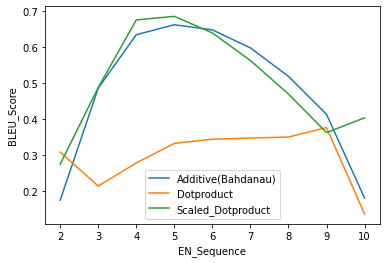

In [ ]:
plt.plot(AdditiveAttention_df.groupby(0)[1].mean(),label='Additive(Bahdanau)')
plt.plot(DotproductAttention_df.groupby(0)[1].mean(),label='Dotproduct')
plt.plot(Scaled_DotproductAttention_df.groupby(0)[1].mean(),label='Scaled_Dotproduct')
plt.legend()
plt.xlabel("EN_Sequence")
plt.ylabel("BLEU_Score")
plt.show()